# Model selection

In this notebook we generate plots to guide models selection for the toolkit. Speficically, we perform the following steps:
1. We convert the HCP retinotopic maps into gitfi files;
2. Visualize predicted/empirical maps from the development set;
3. Estimate model performance (mean error and individual variability) across different model seeds.
4. Illustrate error as a function of variance explained from the empirically estimated maps.


## Import libraries and functions

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import sys
import os
import scipy
import os.path as osp

sys.path.append('..')

from functions.visualization import retinotopic_map_plot
from deepRetinotopy_TheToolbox.utils.rois import ROI_WangParcelsPlusFovea as roi
from ipywidgets import interact, Dropdown


## 1. Save empirical data as gifti files

Here we start by saving each empirically-derived retinotopic map from the [HCP dataset](https://jov.arvojournals.org/article.aspx?articleid=2719988) as individual gifti files so facilitate model selection and benchmarking.

In [ ]:
def get_giftis(hemisphere, prediction, path_to_freesurfer_dir, path_to_converted_data, mask = False, fit = 'fit1'):
    label_primary_visual_areas = ['ROI']
    
    mask_L, mask_R, index_L_mask, index_R_mask = roi(
        label_primary_visual_areas)
    number_cortical_nodes = int(64984)
    number_hemi_nodes = int(number_cortical_nodes / 2)

    if fit == 'fit1':
        data_suffix = '_all'
    elif fit == 'fit2':
        data_suffix = 'fit2_all'
    elif fit == 'fit3':
        data_suffix = 'fit3_all'
        
    for sub_id in os.listdir(path_to_freesurfer_dir):
        if hemisphere == 'rh':
            template = nib.load(osp.join(path_to_freesurfer_dir, sub_id + '/surf/' + sub_id + 
                                     '.curvature-midthickness.rh.32k_fs_LR.func.gii'))
            if prediction == 'polarAngle':
                polarAngle = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                        'cifti_polarAngle_' + data_suffix + '.mat'))['cifti_polarAngle']
                
                retinotopicMap_values = np.reshape(
                    polarAngle['x' + str(sub_id) + 
                                '_'+ fit +'_polarangle_msmall'][0][0][number_hemi_nodes:number_cortical_nodes
                                                                ].reshape((number_hemi_nodes)), (-1, 1)
                                                                )
            elif prediction == 'eccentricity':
                eccentricity = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_eccentricity_' + data_suffix + '.mat'))['cifti_eccentricity']
                retinotopicMap_values = np.reshape(
                    eccentricity['x' + str(sub_id) + 
                                 '_'+ fit +'_eccentricity_msmall'][0][0][number_hemi_nodes:number_cortical_nodes
                                                                    ].reshape((number_hemi_nodes)), (-1, 1)
                                                                    )
            elif prediction == 'pRFsize':
                prfsize = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_pRFsize_' + data_suffix + '.mat'))['cifti_pRFsize']
                retinotopicMap_values = np.reshape(
                    prfsize['x' + str(sub_id) + 
                             '_'+ fit +'_receptivefieldsize_msmall'][0][0][number_hemi_nodes:number_cortical_nodes
                                                                    ].reshape((number_hemi_nodes)), (-1, 1)
                                                                    )
            elif prediction == 'variance_explained':
                variance = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_R2_all.mat'))['cifti_R2']
                retinotopicMap_values = np.reshape(
                    variance['x' + str(sub_id) + '_'+ fit +'_r2_msmall'][0][0][number_hemi_nodes:number_cortical_nodes
                                                                    ].reshape((number_hemi_nodes)), (-1, 1)
                                                                    )
            if mask==True:
                retinotopicMap_values[mask_R != 1] = -1
        elif hemisphere == 'lh':
            template = nib.load(osp.join(path_to_freesurfer_dir, sub_id + '/surf/' + sub_id + 
                                     '.curvature-midthickness.lh.32k_fs_LR.func.gii'))
            if prediction == 'polarAngle':
                polarAngle = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                        'cifti_polarAngle_' + data_suffix + '.mat'))['cifti_polarAngle']
                
                retinotopicMap_values = np.reshape(
                    polarAngle['x' + str(sub_id) + '_' + fit +'_polarangle_msmall'][0][
                        0][0:number_hemi_nodes].reshape((number_hemi_nodes)), (-1, 1))
                # Shifting polar angle values to match model's output
                sum_180 = retinotopicMap_values < 180
                minus_180 = retinotopicMap_values > 180
                retinotopicMap_values[sum_180] = retinotopicMap_values[sum_180] + 180
                retinotopicMap_values[minus_180] = retinotopicMap_values[minus_180] - 180
            
            elif prediction == 'eccentricity':
                eccentricity = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_eccentricity_' + data_suffix + '.mat'))['cifti_eccentricity']
                retinotopicMap_values = np.reshape(
                    eccentricity['x' + str(sub_id) + '_'+ fit +'_eccentricity_msmall'][
                        0][0][0:number_hemi_nodes].reshape((number_hemi_nodes)), (-1, 1))
            elif prediction == 'pRFsize':
                prfsize = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_pRFsize_' + data_suffix + '.mat'))['cifti_pRFsize']
                retinotopicMap_values = np.reshape(
                    prfsize['x' + str(sub_id) + '_'+ fit +'_receptivefieldsize_msmall'][
                        0][0][0:number_hemi_nodes].reshape((number_hemi_nodes)), (-1, 1))
            elif prediction == 'variance_explained':
                variance = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_R2_all.mat'))['cifti_R2']
                retinotopicMap_values = np.reshape(
                    variance['x' + str(sub_id) + '_'+ fit +'_r2_msmall'][
                        0][0][0:number_hemi_nodes].reshape((number_hemi_nodes)), (-1, 1))
            
            if mask==True:
                retinotopicMap_values[mask_L != 1] = -1

        retinotopicMap_values = np.reshape(retinotopicMap_values, (number_hemi_nodes,1))
        template.agg_data()[:] = np.reshape(retinotopicMap_values, (-1))

        if fit == 'fit1':
            fit = ''

        if hemisphere == 'lh':
            if mask==False:
                nib.save(template, path_to_freesurfer_dir + sub_id + '/surf/' + sub_id + '.fs_empirical_' + prediction +
                                        '_lh_' + fit + '.func.gii')
            if mask==True:
                nib.save(template, path_to_freesurfer_dir + sub_id + '/surf/' + sub_id + '.fs_empirical_' + prediction +
                                        '_lh_masked_' + fit + '.func.gii')
        elif hemisphere == 'rh':
            if mask==False:
                nib.save(template, path_to_freesurfer_dir + sub_id + '/surf/' + sub_id + '.fs_empirical_' + prediction +
                                            '_rh_' + fit + '.func.gii')  
            if mask==True:
                nib.save(template, path_to_freesurfer_dir + sub_id + '/surf/' + sub_id + '.fs_empirical_' + prediction +
                                        '_rh_masked_' + fit + '.func.gii')
        print('Empirical map has been saved as ' + sub_id + '.fs_empirical_' + prediction + '_' + hemisphere + '_' + fit + '.func.gii')
    return 

In [ ]:
path_to_freesurfer_dir = '../HCP/freesurfer/'
path_to_converted_data = '../HCP/raw/converted/'
retinotopic_map = ['variance_explained', 'polarAngle', 'eccentricity', 'pRFsize',] 

for hemisphere in ['lh', 'rh']:
    for prediction in retinotopic_map:
        for fit in ['fit1', 'fit2', 'fit3']:
            get_giftis(hemisphere, prediction, path_to_freesurfer_dir, path_to_converted_data, mask = False, fit = fit)
            get_giftis(hemisphere, prediction, path_to_freesurfer_dir, path_to_converted_data, mask = True, fit = fit)

## 2. Visualization of empirical and predicted maps of the dev set

In [ ]:
path_to_freesurfer = './../HCP/freesurfer/'

subject_id = ['186949', '169747', '826353', '825048', '671855',
                        '751550', '318637', '131722', '137128', '706040'] # dev set
prediction = Dropdown(options = ['empirical', 'predicted', '1', '2', '3', '4', '5'])
retinotopic_map = ['polarAngle', 'eccentricity', 'pRFsize']
binarize = Dropdown(options = [False, True])
hemisphere = Dropdown(options = ['lh', 'rh'])

@interact(subject_id=subject_id, prediction = prediction, 
          binarize = binarize, retinotopic_map = retinotopic_map,
          hemisphere = hemisphere)
def plot1(subject_id,prediction, binarize, retinotopic_map, hemisphere):
    return retinotopic_map_plot(subject_id, path_to_freesurfer, '../templates',
                                 prediction = prediction, binarize = binarize,
                                 retinotopic_map = retinotopic_map, hemisphere = hemisphere)

interactive(children=(Dropdown(description='subject_id', options=('186949', '169747', '826353', '825048', '671…

## 3. Performance estimation for model selection

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

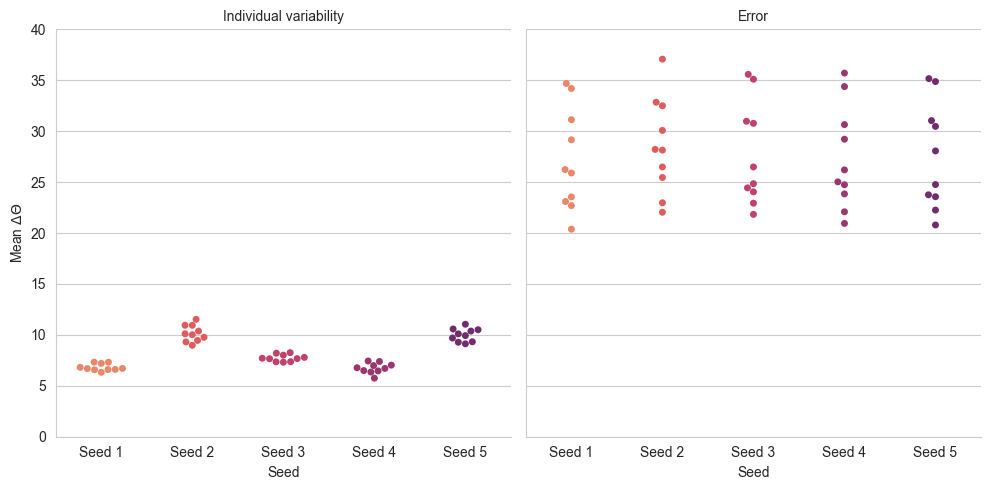

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

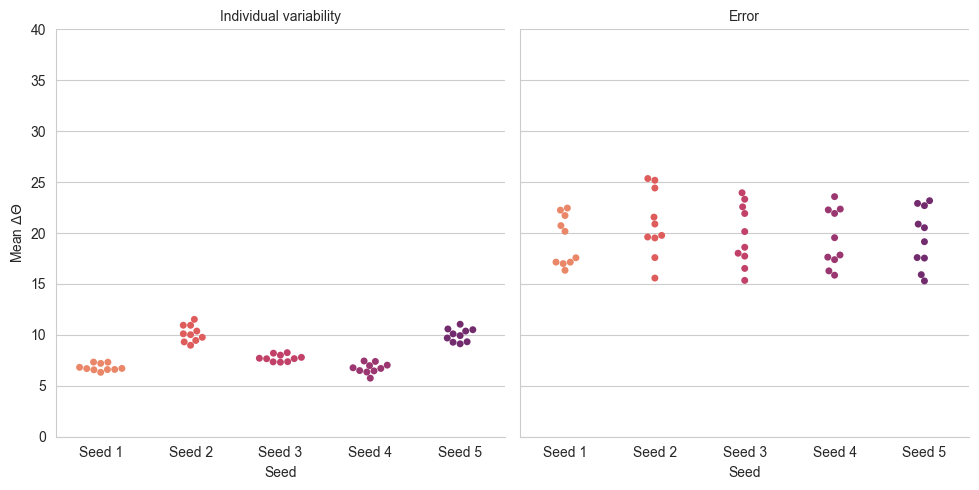

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

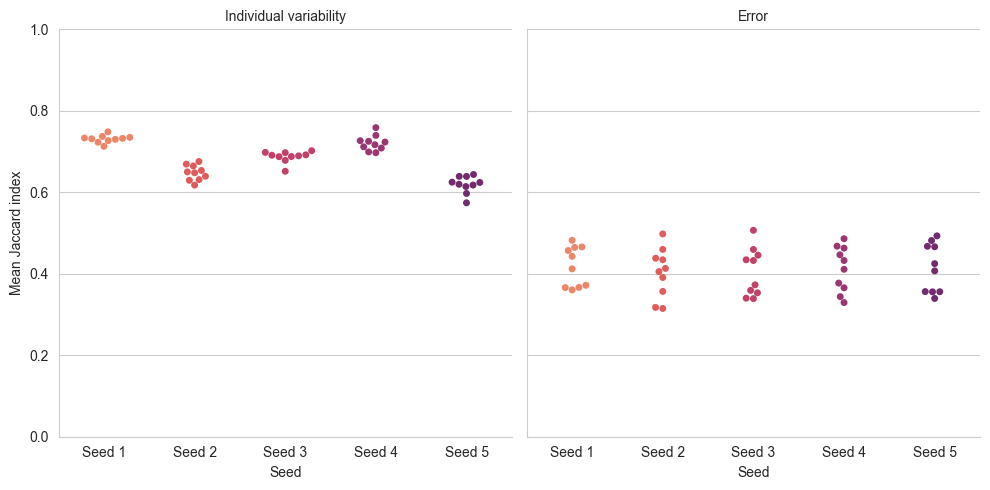

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

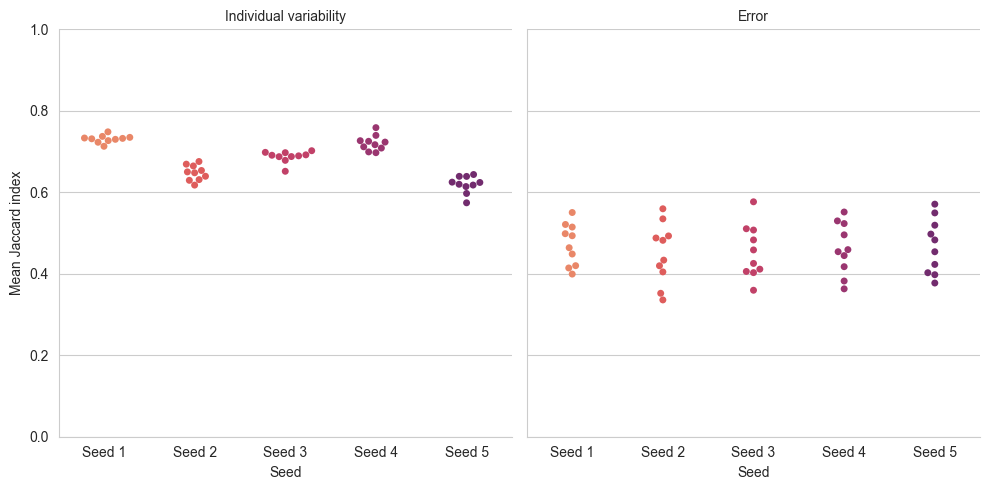

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

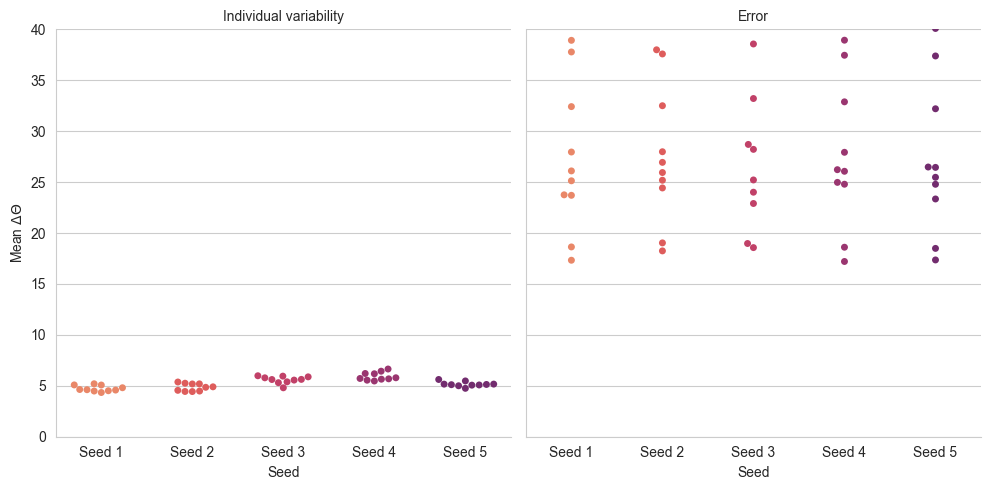

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

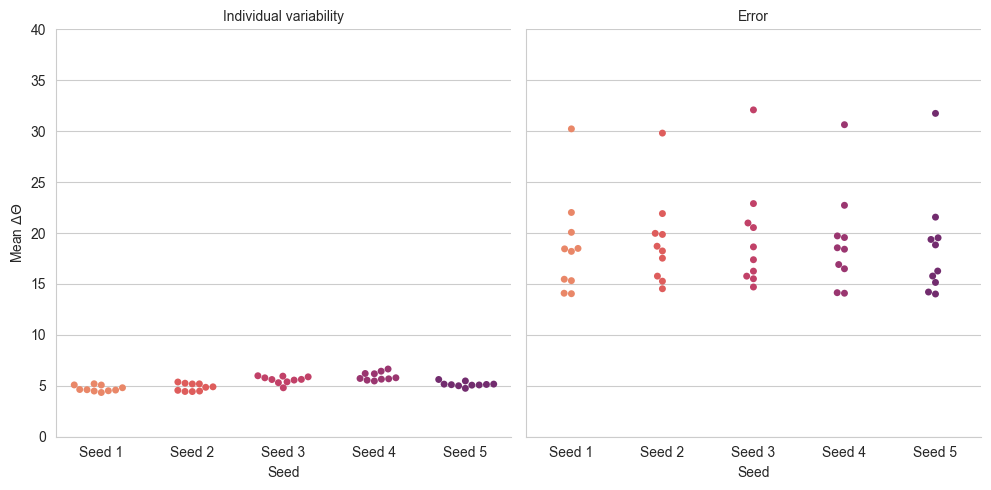

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

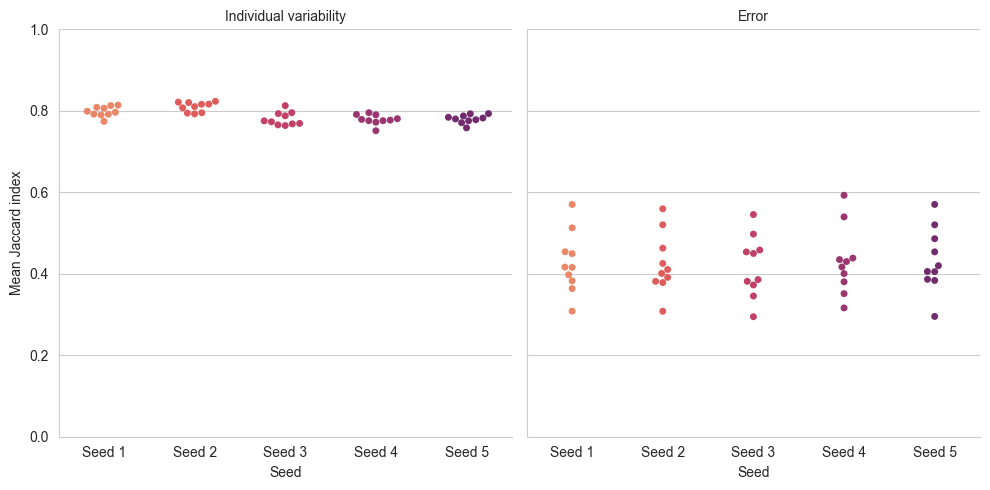

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

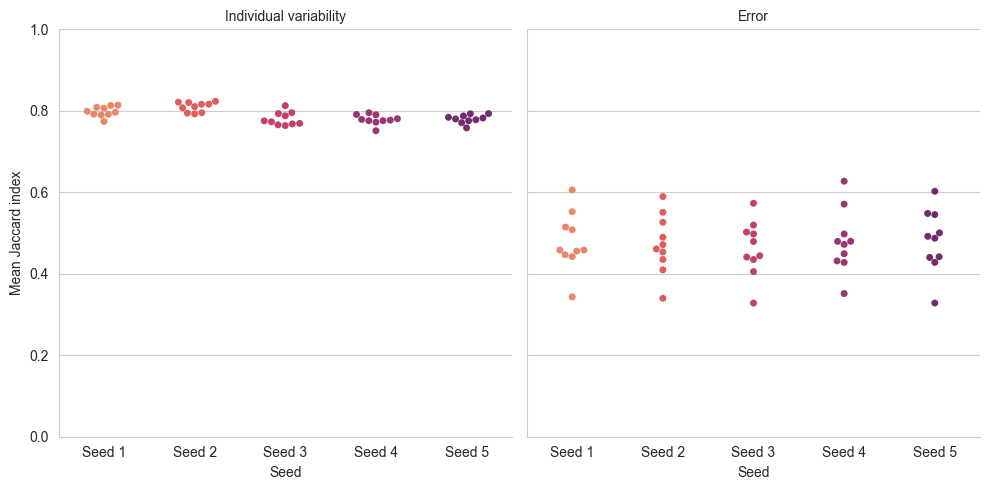

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

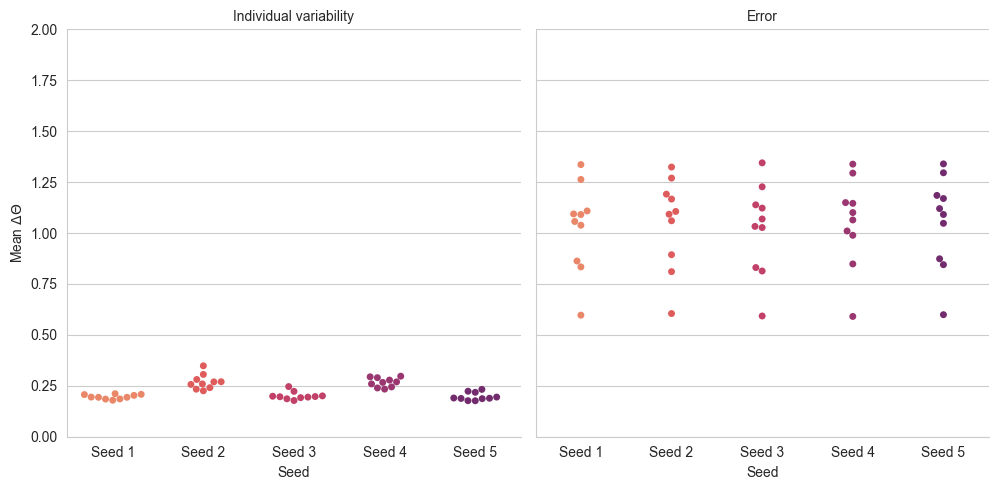

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

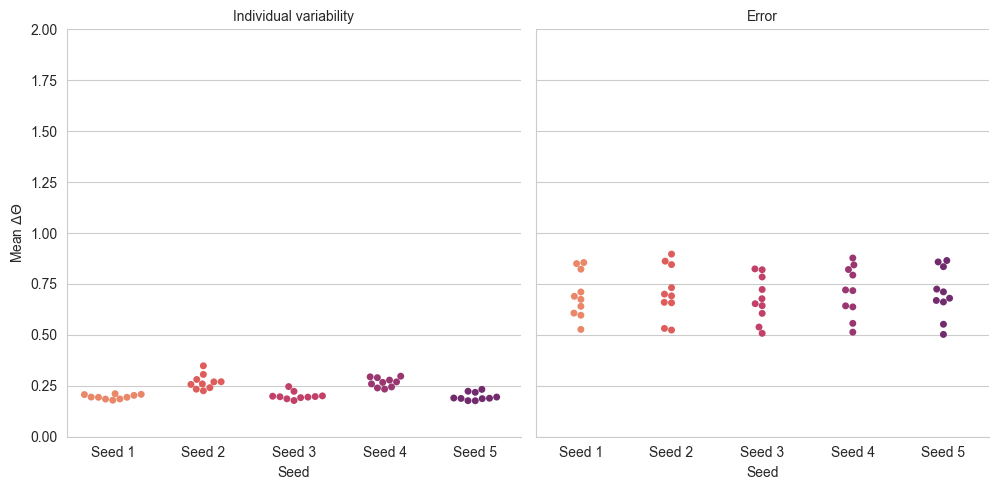

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

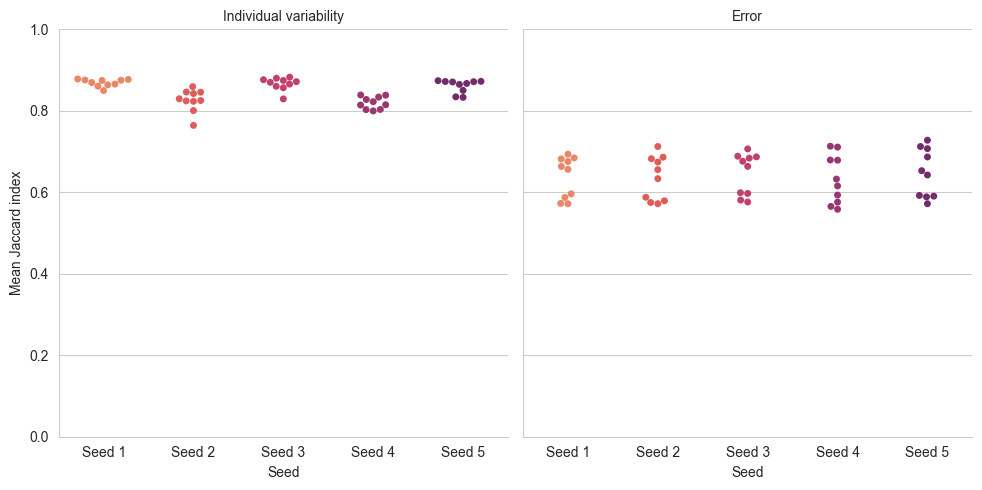

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

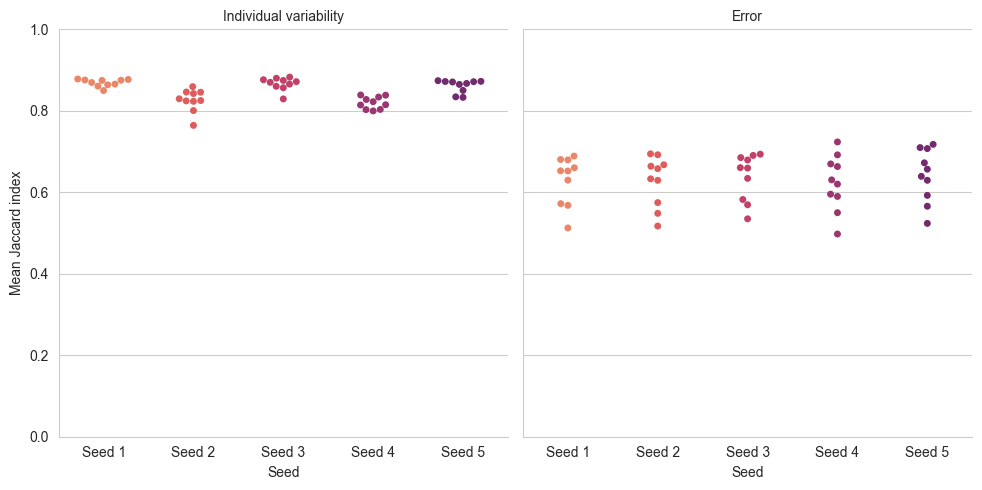

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

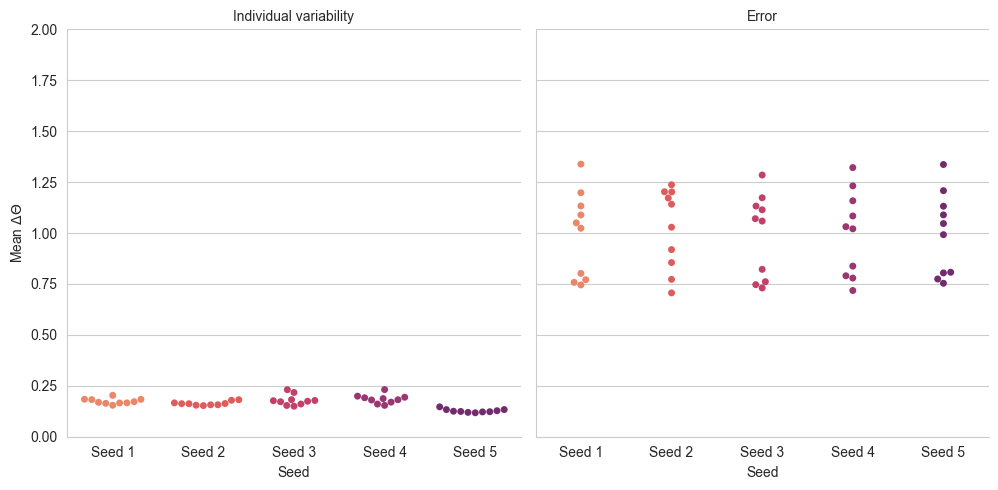

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

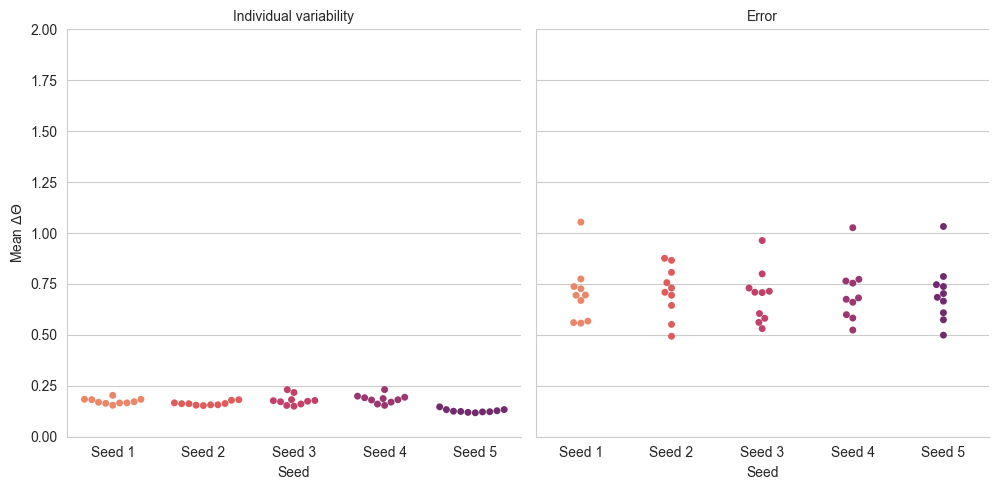

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

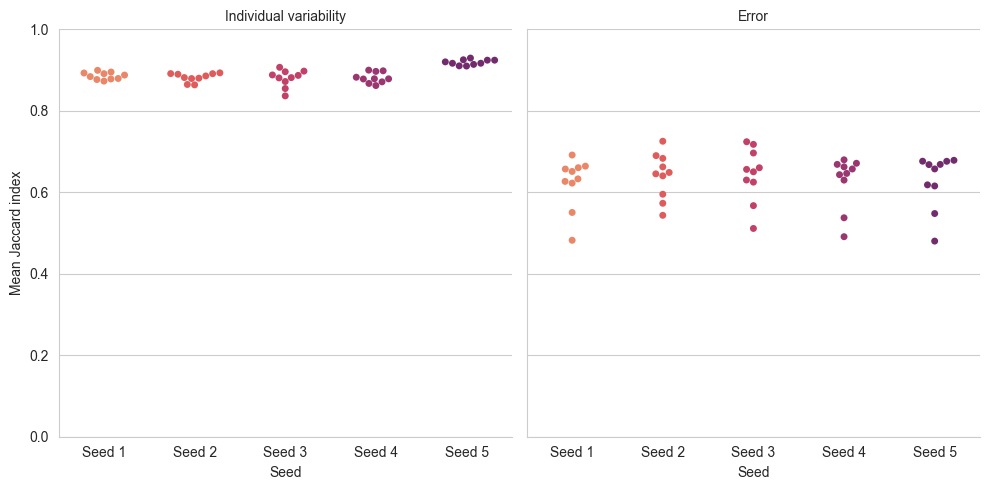

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

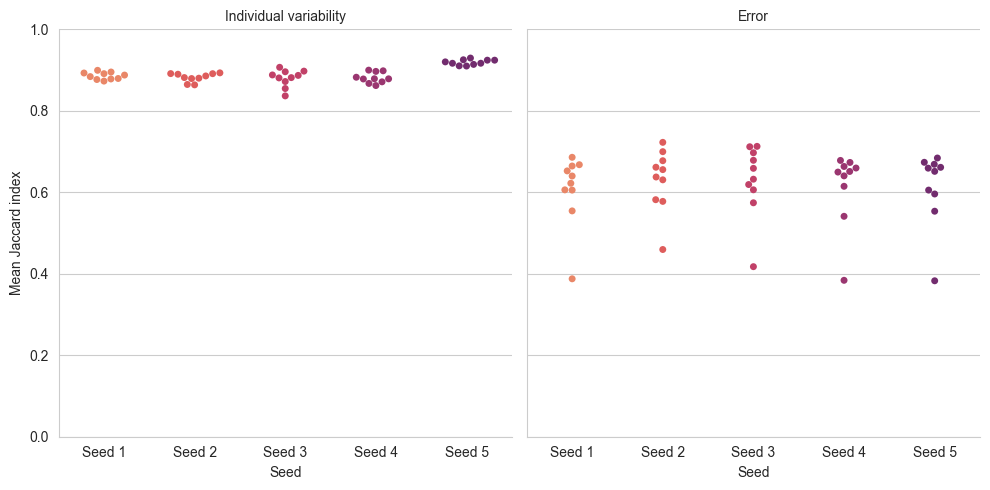

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

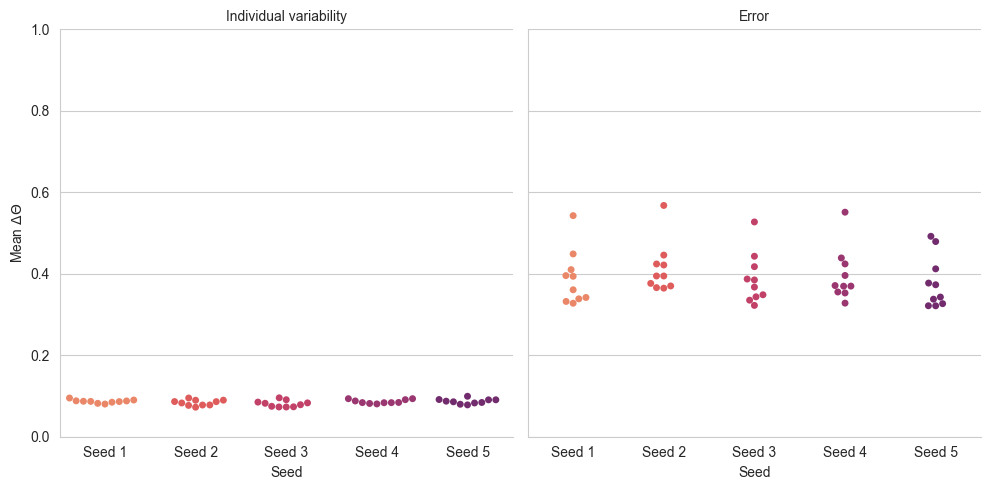

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

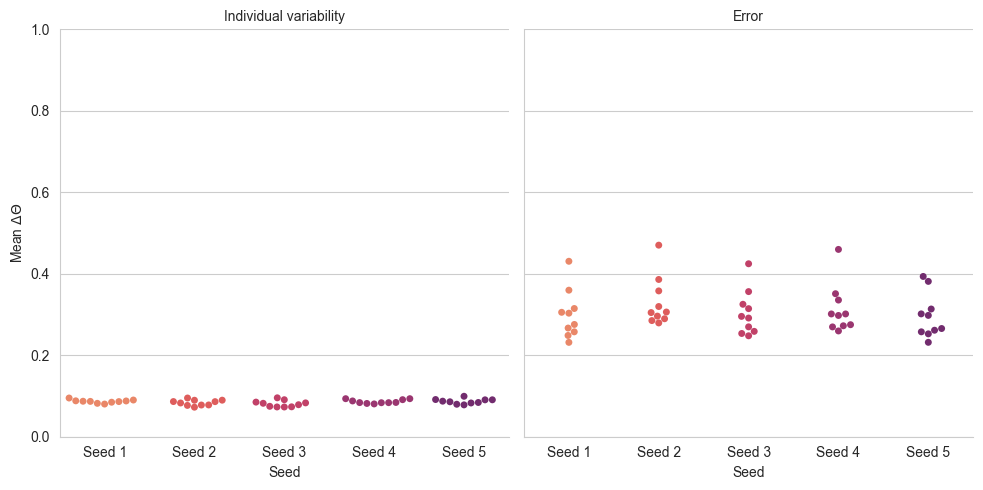

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

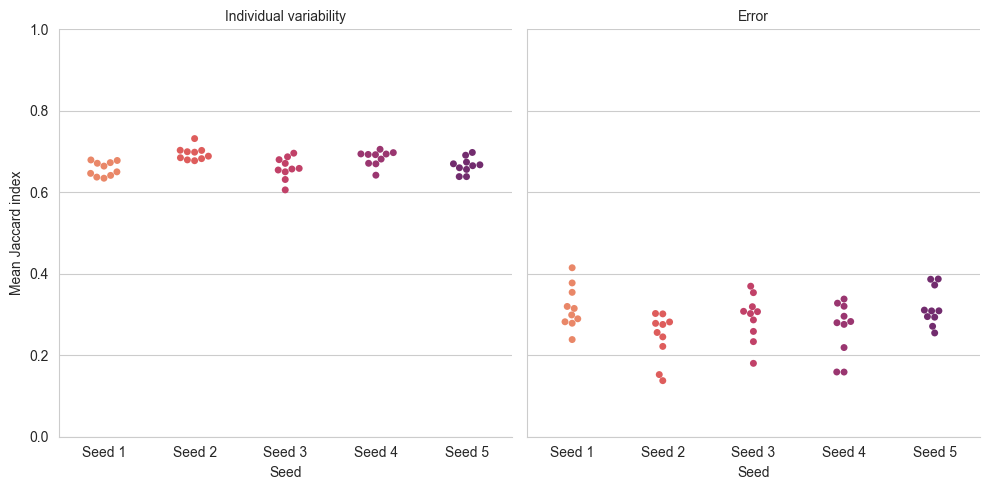

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

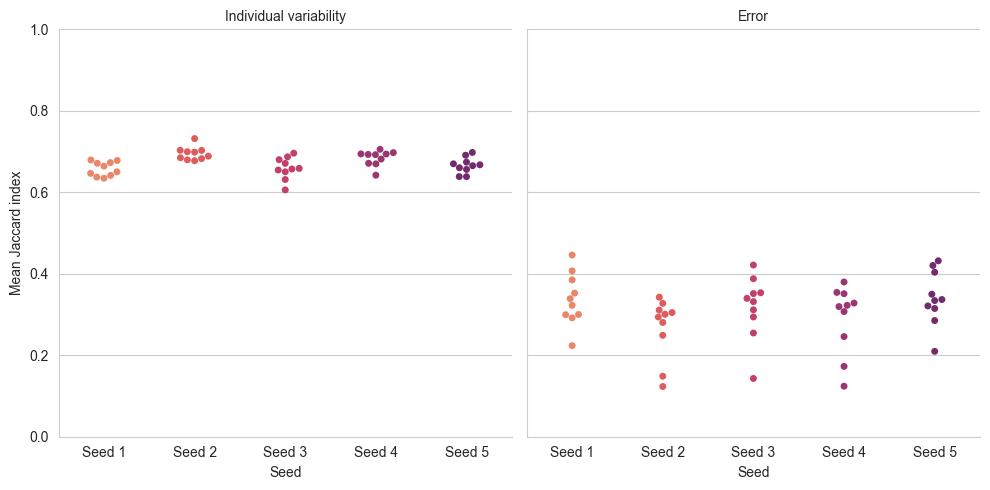

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

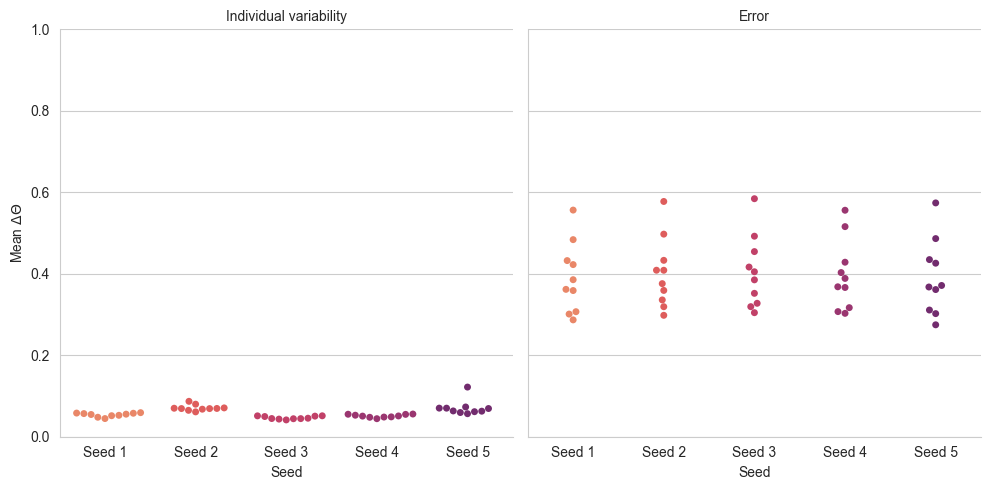

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

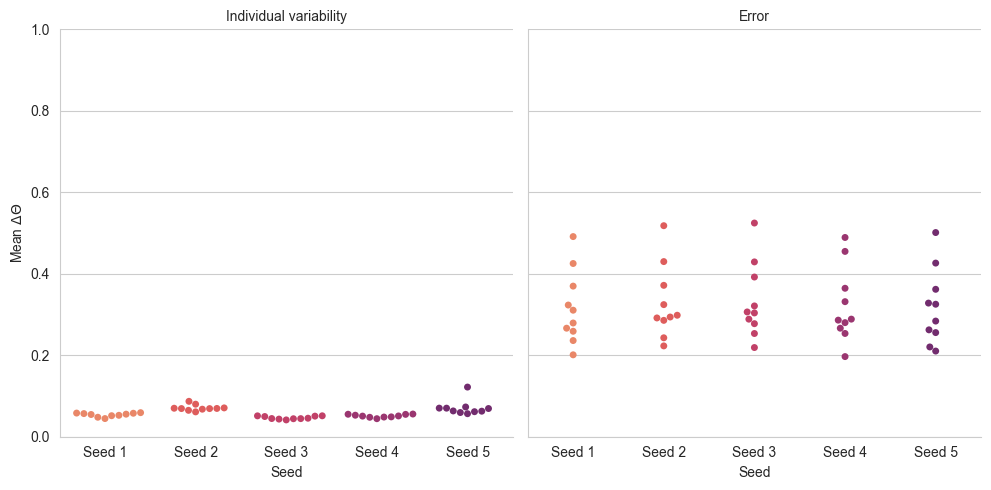

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

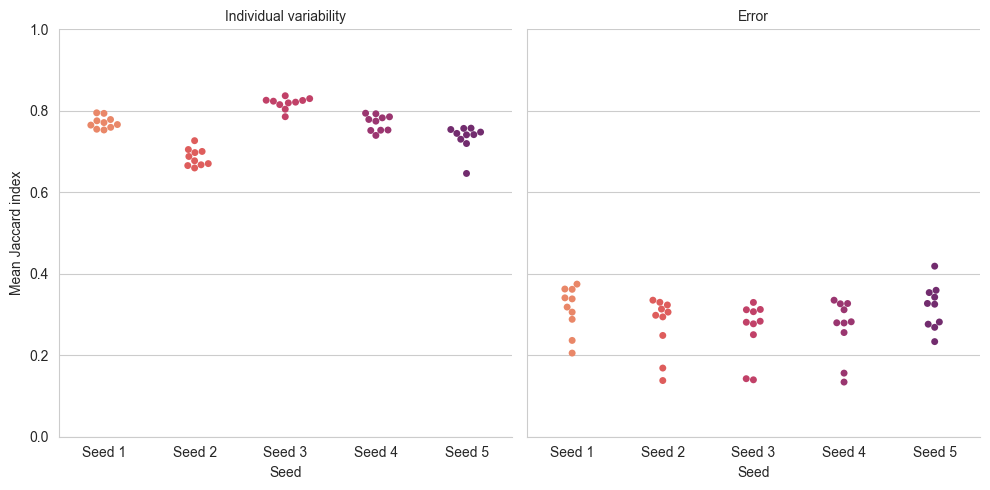

Model 1 of 5
Model 2 of 5
Model 3 of 5
Model 4 of 5
Model 5 of 5


<Figure size 640x480 with 0 Axes>

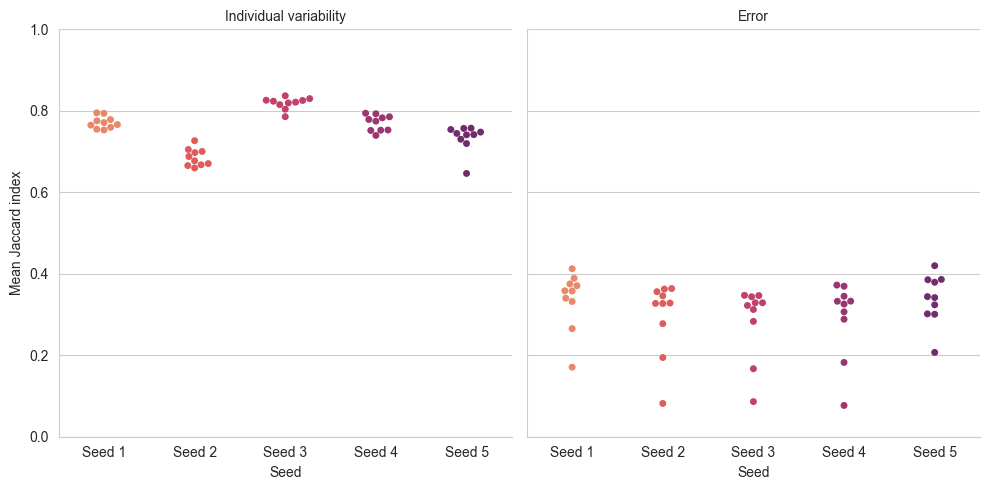

In [2]:
from functions.evaluation import metric_model_selection

retinotopic_maps = ['polarAngle','eccentricity','pRFsize']

for retinotopic_map in retinotopic_maps:
    for hemisphere in ['lh', 'rh']:
        for retinotopic_mapping in ['continuous', 'discrete']:
            for threshold in [None, 10]:
                data = metric_model_selection('../HCP/freesurfer/', retinotopic_map, hemisphere, retinotopic_mapping, threshold=threshold)
                # data.to_csv('../output/' + retinotopic_map + '_' + hemisphere + '_' + retinotopic_mapping + '.xlsx')

## 4. Visualising error as a function of variance explained 


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


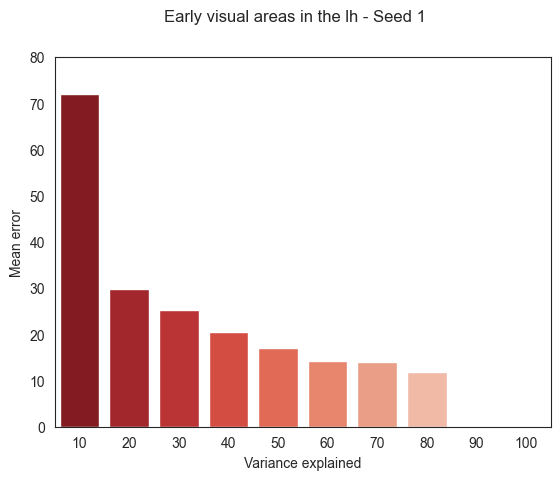

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


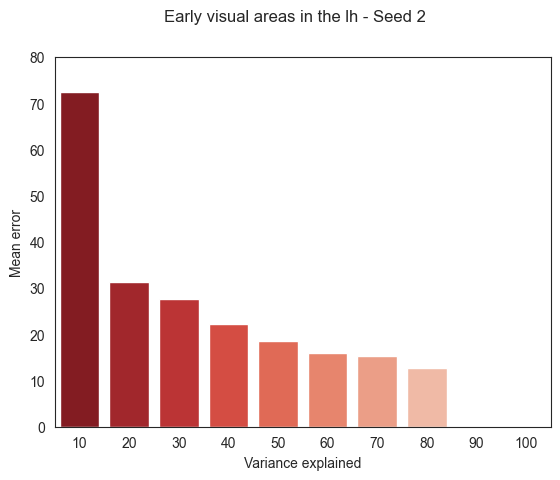

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


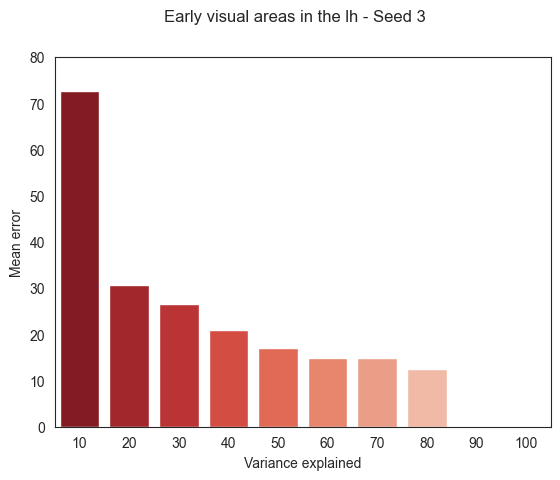

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


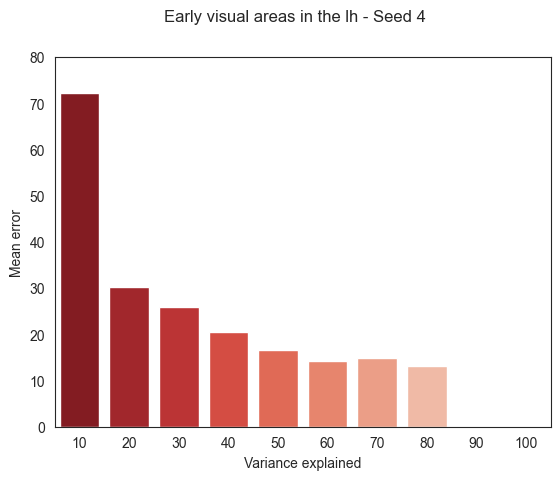

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


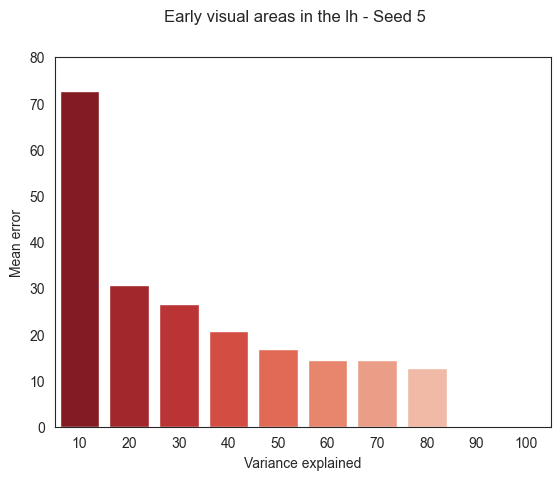

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


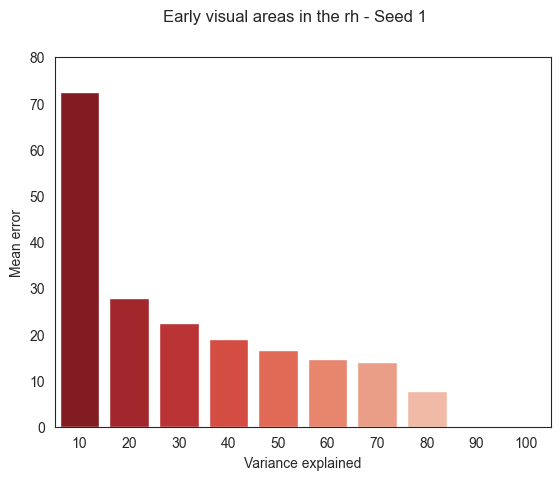

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


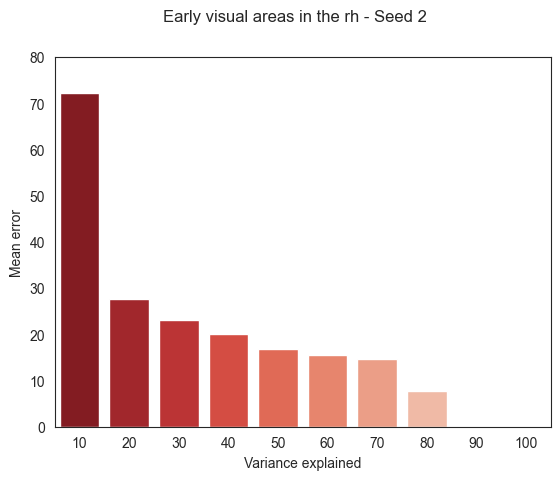

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


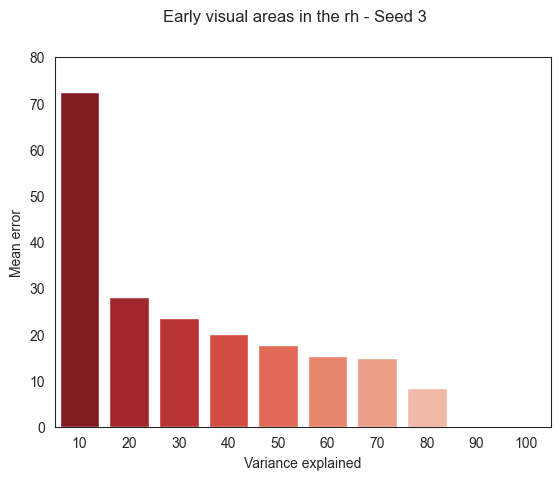

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


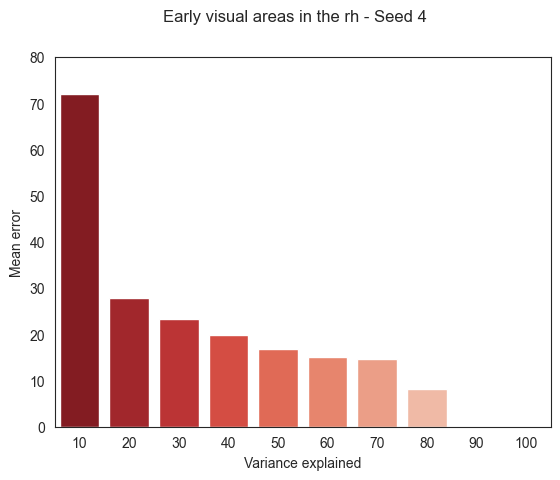

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


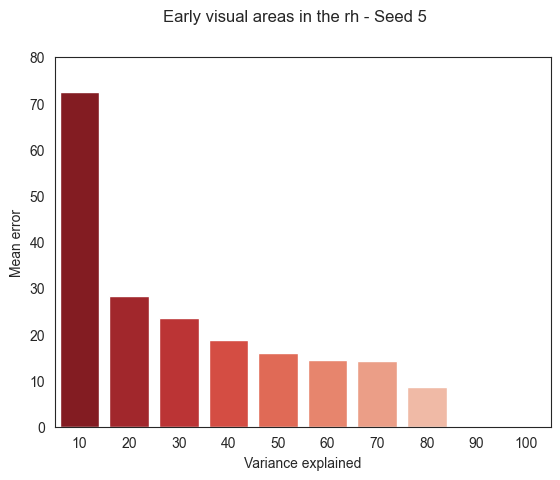

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


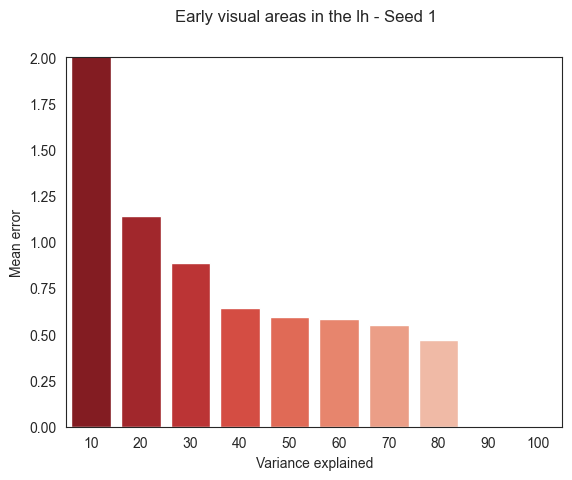

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


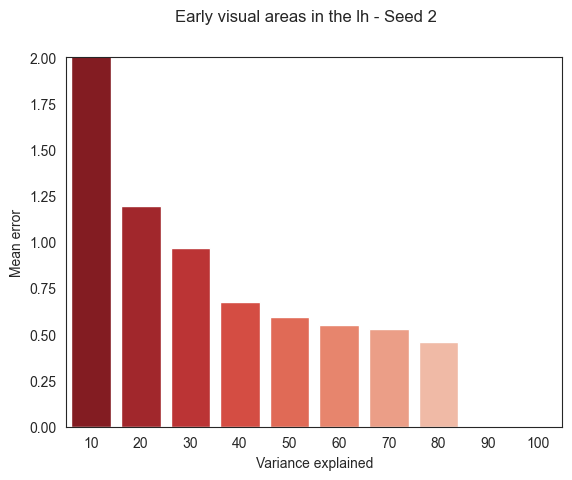

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


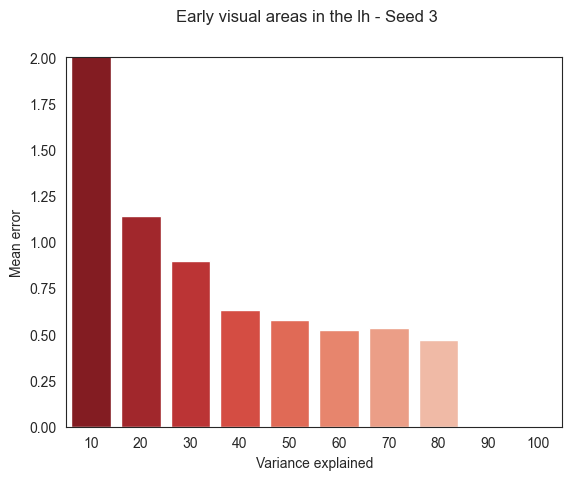

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


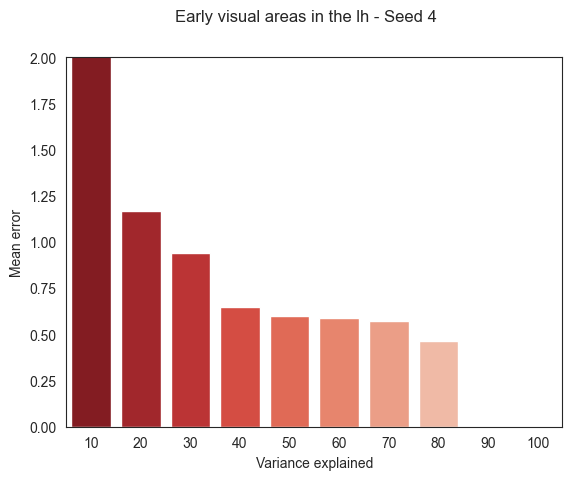

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


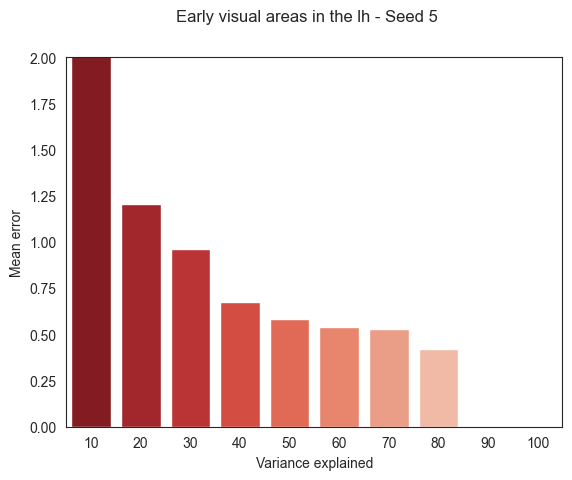

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


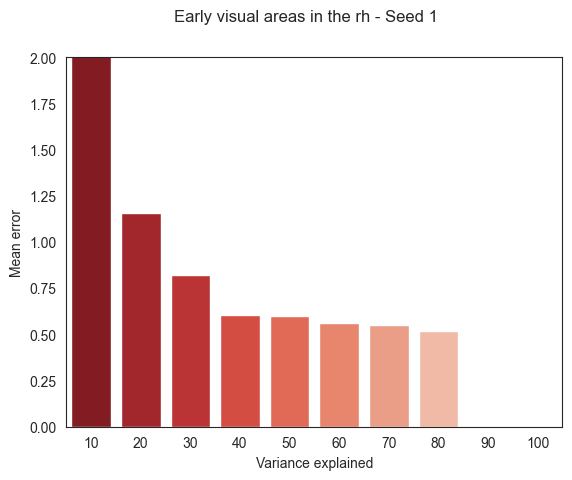

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


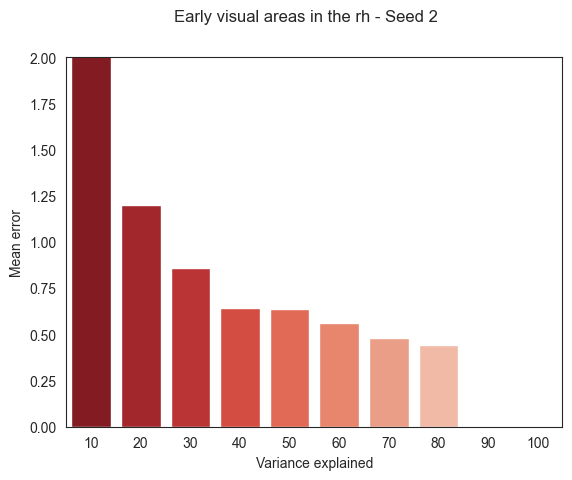

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


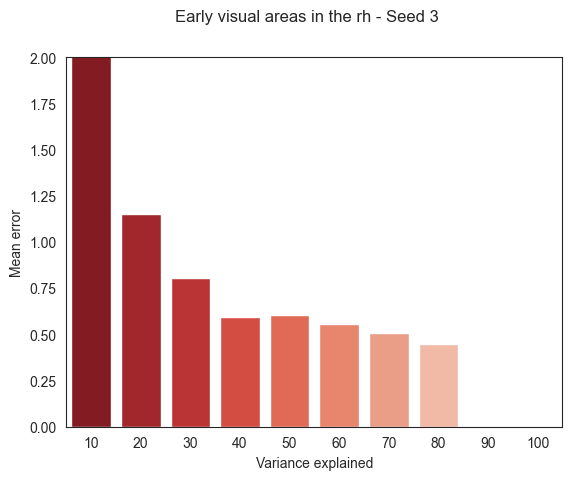

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


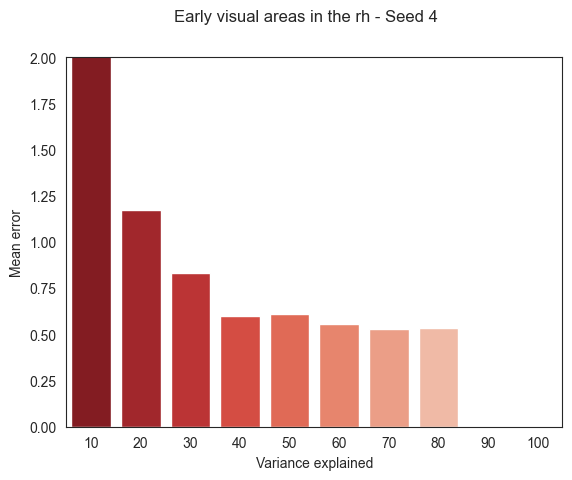

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


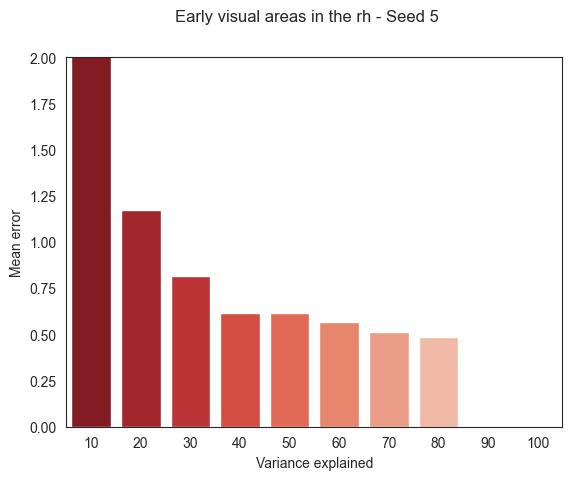

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


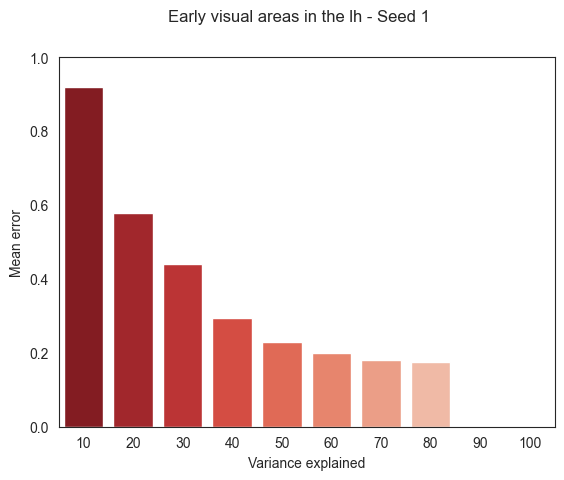

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


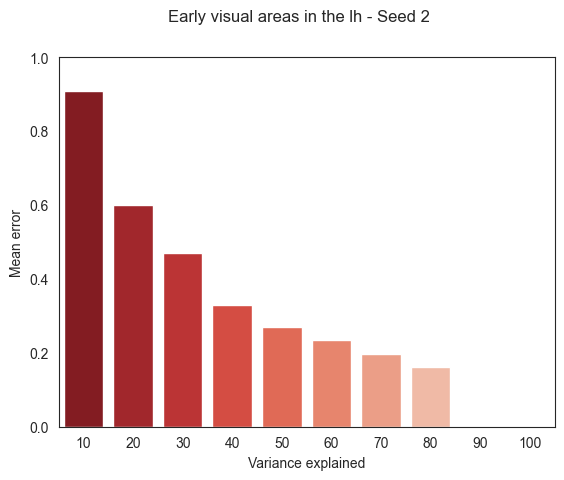

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


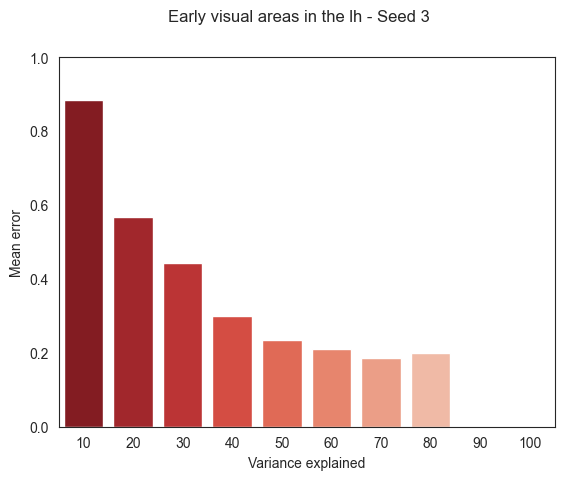

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


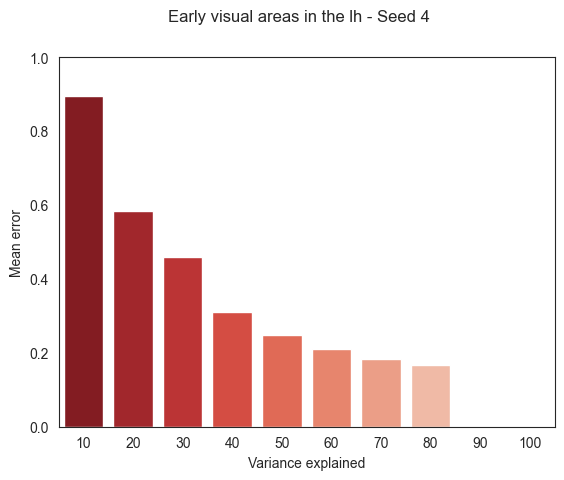

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


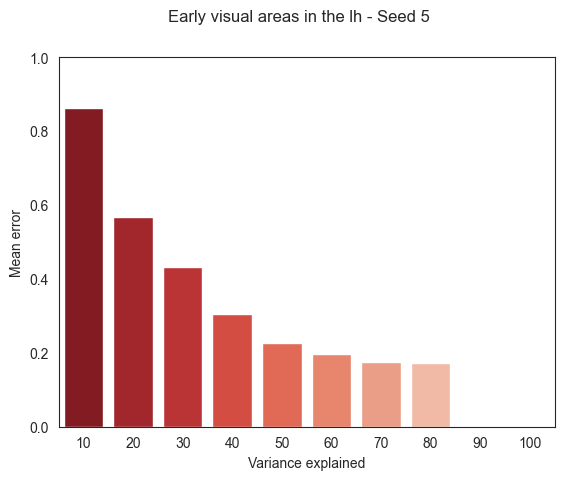

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


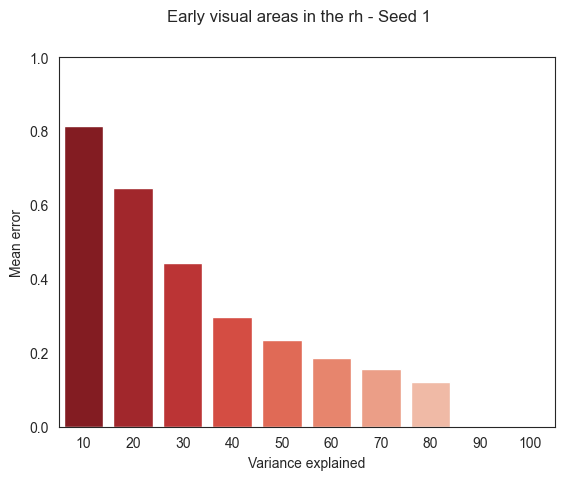

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


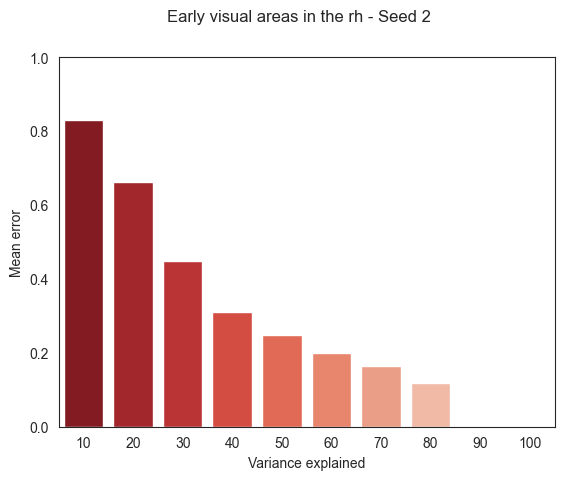

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


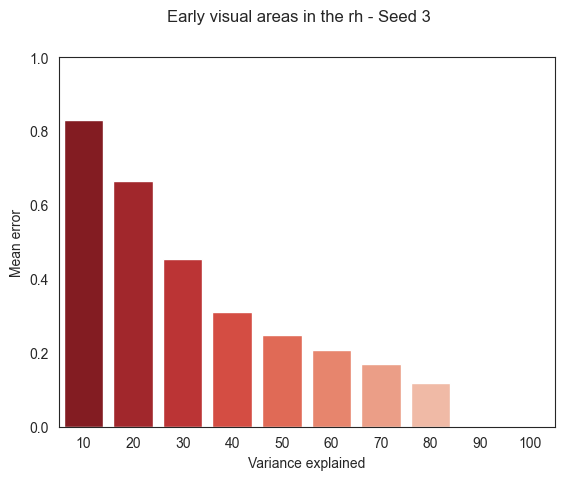

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


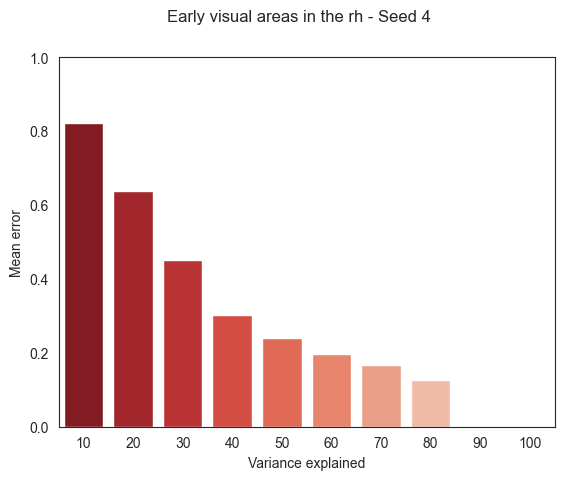

/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


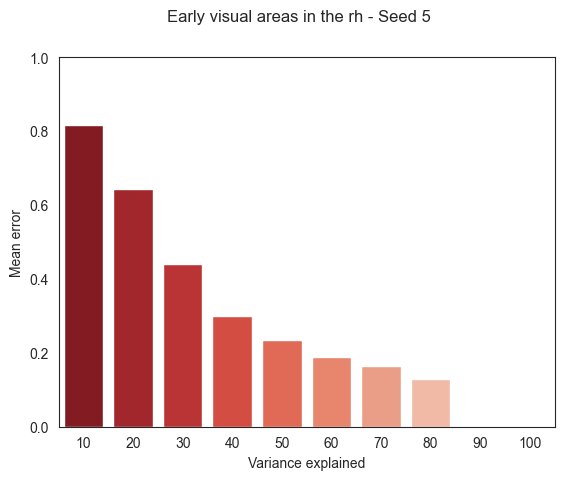

In [4]:
from functions.evaluation import explainedvariance_vs_error

retinotopic_maps = ['polarAngle','eccentricity','pRFsize']

for retinotopic_map in retinotopic_maps:
    for hemisphere in ['lh', 'rh']:
        data = explainedvariance_vs_error('../HCP/freesurfer/', retinotopic_map, hemisphere, threshold = None)